# Introduction to Regularization for Deep Neural Nets

## Stephen Elston
## Machine Learning 410

This lesson will introduce you to the principles of regularization required to successfully train deep neural networks. In this lesson you will:

1. Understand the need for regularization of complex machine learning models, particularly deep NNs. 
2. Know how to apply constriant-based regularization using the L1 and L2 norms.
3. Understand and apply the concept of data augmentation. 
4. Know how to apply dropout regularization. 
5. Understand the advantages of various regulariztion methods and know when how to apply them in combination. 

## Why do we need regularization

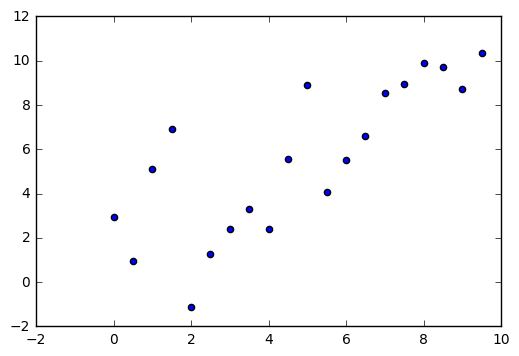

In [96]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import normal, seed
seed(34567)
x = np.arange(start = 0.0, stop = 10.0, step = 0.5) 
y = np.add(x, normal(scale = 2.0, size = x.shape[0]))

plt.scatter(x,y)

[ 0.91017709]


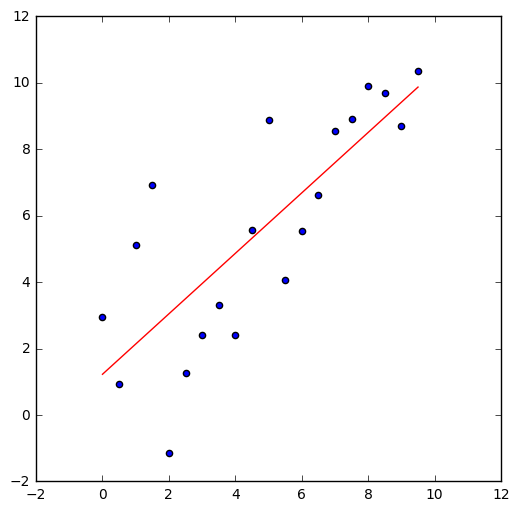

In [104]:
import sklearn.linear_model as slm
from sklearn.preprocessing import scale
mod = slm.LinearRegression()
x = x.reshape(-1, 1)
x_scale = scale(x)
y = np.reshape(y, y.shape[0])
mod.fit(x,y)
y_hat = mod.predict(x)
print(mod.coef_)

ax = plt.figure(figsize=(6, 6)).gca() # define axis
plt.plot(x,y_hat, c = 'red')
plt.scatter(x,y)

(20, 9)
[ -7.65737206e+01   2.22075223e+03  -2.08565697e+04   9.48808693e+04
  -2.41489721e+05   3.62778141e+05  -3.19877587e+05   1.53199763e+05
  -3.07765164e+04]


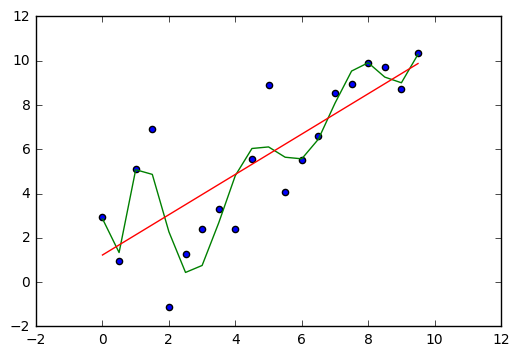

In [105]:
seed(2233)
x_power = np.power(x, range(1,10)) # [1,2,3,4,5,6,7,8,9,10])
print(x_power.shape)
x_power = scale(x_power)

mod_pow = slm.LinearRegression()
mod_pow.fit(x_power, y)
y_hat_power = mod_pow.predict(x_power)
print(mod_pow.coef_)

plt.plot(x,y_hat_power, c = 'green')
plt.plot(x,y_hat, c = 'red')
plt.scatter(x,y)

[ 0.55525263  1.20411485  1.02699663  0.63787237  0.26975752 -0.02297301
 -0.24153809 -0.39854572 -0.50618995]


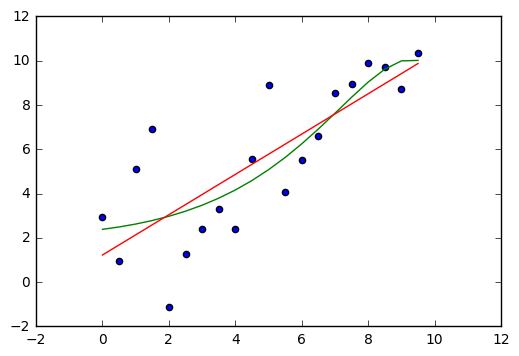

In [108]:
mod_L2 = slm.Ridge(alpha = 1.0)
mod_L2.fit(x_power, y)
y_hat_L2 = mod_L2.predict(x_power)
print(mod_L2.coef_)

plt.plot(x,y_hat_L2, c = 'green')
plt.plot(x,y_hat, c = 'red')
plt.scatter(x,y)

[ 0.21240035  2.29142585  0.          0.          0.          0.         -0.
 -0.         -0.        ]


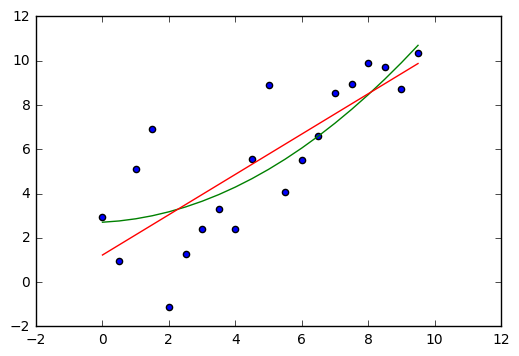

In [113]:
mod_L1 = slm.Lasso(alpha = 0.2, max_iter=100000)
mod_L1.fit(x_power, y)
y_hat_L1 = mod_L1.predict(x_power)
print(mod_L1.coef_)

plt.plot(x,y_hat_L1, c = 'green')
plt.plot(x,y_hat, c = 'red')
plt.scatter(x,y)